In [12]:
# === Local Settings (v5) ===
from pathlib import Path

USE_GPU = True  # GPUがない場合はFalseにする
DATA_PATH = Path("usd_jpy_1min_20231028_20260131_utc.parquet")
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)

def catboost_device_params():
    return {"task_type": "GPU", "devices": "0"} if USE_GPU else {"task_type": "CPU"}

try:
    from google.colab import files  # type: ignore
    _HAS_COLAB = True
except Exception:
    _HAS_COLAB = False

def maybe_download(path: Path):
    if _HAS_COLAB:
        files.download(str(path))
    else:
        print(f"📁 Saved locally: {path}")

In [13]:
# === Cell 1: Setup Environment (v5) ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import optuna
import shap
import pickle
import warnings
import random
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    log_loss, classification_report, accuracy_score,
    confusion_matrix, precision_recall_fscore_support,
    cohen_kappa_score, f1_score
)
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# === Configuration (v5: Purged CV + Trading Objective) ===
CONFIG = {
    # ターゲット設定
    'PREDICT_HORIZON': 15,           # 予測期間（分）
    'THRESHOLD_PIPS_MIN': 2,         # v5: 閾値最適化範囲（pips）
    'THRESHOLD_PIPS_MAX': 10,        # v5: 閾値最適化範囲（pips）
    'THRESHOLD_PIPS_DEFAULT': 5,     # デフォルト値（pips）

    # 特徴量選択
    'TOP_N_FEATURES': 40,

    # モデル設定
    'RANDOM_SEED': 42,
    'N_TRIALS': 50,
    'CV_SPLITS': 5,

    # データ分割比率
    'TRAIN_RATIO': 0.6,
    'VAL_RATIO': 0.2,
    'TEST_RATIO': 0.2,

    # コスト設定（pips）
    'PIP_SIZE': 0.01,                # USD/JPY: 1 pip = 0.01
    'SPREAD_PIPS': 0.4,              # スプレッド（pips）
    'SLIPPAGE_PIPS': 0.05,           # スリッページ（pips）

    # バックテスト設定
    'POSITION_SIZE': 10000,          # ポジションサイズ（通貨単位）

    # 推論設定
    'BAD_HOURS': [20, 21, 22, 23],   # スプレッド異常時間帯（UTC）
    'ATR_PERCENTILE': 30,            # ATRフィルタの閾値パーセンタイル
    'TIMEZONE': 'UTC',

    # 最適化制約
    'MIN_TRADES': 300,               # 最低トレード数
    'MIN_TRADE_RATE': 0.003,         # 取引率下限（0.3%）
    'MIN_SIDE_TRADES': 20,           # Buy/Sellの最低トレード数

    # 予測確率の下限（Optunaで最適化）
    'PROB_THRESHOLD_MIN': 0.30,
    'PROB_THRESHOLD_MAX': 0.70,
}

# purge gap = 予測期間
CONFIG['CV_GAP'] = CONFIG['PREDICT_HORIZON']

np.random.seed(CONFIG['RANDOM_SEED'])
random.seed(CONFIG['RANDOM_SEED'])

print("✅ Libraries installed and imported.")
print("📊 Configuration (v5):")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")


c:\Users\daiya\OneDrive\ドキュメント\FX-speculate\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Libraries installed and imported.
📊 Configuration (v5):
   PREDICT_HORIZON: 15
   THRESHOLD_PIPS_MIN: 2
   THRESHOLD_PIPS_MAX: 10
   THRESHOLD_PIPS_DEFAULT: 5
   TOP_N_FEATURES: 40
   RANDOM_SEED: 42
   N_TRIALS: 1
   CV_SPLITS: 5
   TRAIN_RATIO: 0.6
   VAL_RATIO: 0.2
   TEST_RATIO: 0.2
   PIP_SIZE: 0.01
   SPREAD_PIPS: 0.4
   SLIPPAGE_PIPS: 0.05
   POSITION_SIZE: 10000
   BAD_HOURS: [20, 21, 22, 23]
   ATR_PERCENTILE: 30
   TIMEZONE: UTC
   MIN_TRADES: 300
   MIN_TRADE_RATE: 0.003
   MIN_SIDE_TRADES: 20
   PROB_THRESHOLD_MIN: 0.3
   PROB_THRESHOLD_MAX: 0.7
   CV_GAP: 15


⏳ Loading Data & Generating Features (v5)...

📊 Data Prepared: 833344 rows, 95 features

📈 Class Distribution (threshold 5 pips):
   Hold: 483,039 (57.96%)
   Buy: 178,347 (21.40%)
   Sell: 171,958 (20.63%)


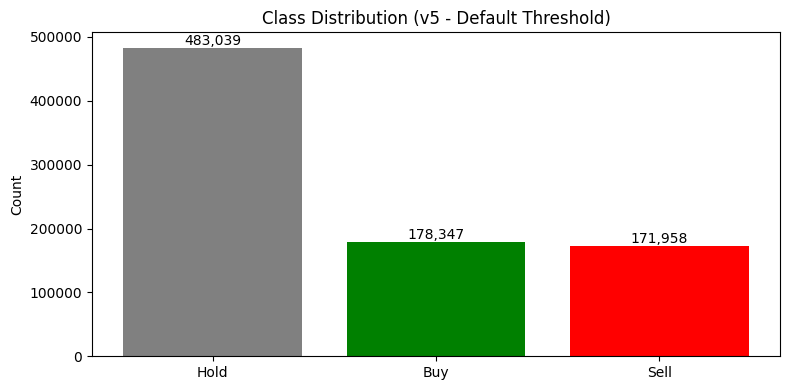

In [14]:
# === Cell 2: Data Loading & Feature Engineering (v5) ===
print("⏳ Loading Data & Generating Features (v5)...")

# 1. データ読み込み
file_path = DATA_PATH
df = pd.read_parquet(file_path)

if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
elif 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
df.sort_index(inplace=True)

# 必須カラム補完
if 'close' not in df.columns:
    if 'ask_close' in df.columns and 'bid_close' in df.columns:
        df['close'] = (df['ask_close'] + df['bid_close']) / 2
    else:
        df['close'] = df.iloc[:, 0]
if 'volume' not in df.columns:
    df['volume'] = df.get('tick_volume', 1.0)

# 2. TA特徴量生成
df_features = df.copy()
c_open = 'ask_open' if 'ask_open' in df.columns else 'ask_close'
c_high = 'ask_high' if 'ask_high' in df.columns else 'ask_close'
c_low = 'ask_low' if 'ask_low' in df.columns else 'ask_close'

df_features = ta.add_all_ta_features(
    df_features, open=c_open, high=c_high, low=c_low,
    close="close", volume="volume", fillna=True
)

# 3. 数値列のみ抽出
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
exclude_keywords = ['ask_', 'bid_', 'timestamp', 'future', 'target', 'tick_', 'open', 'high', 'low', 'close', 'volume']
feature_cols = [c for c in numeric_cols if not any(k in c for k in exclude_keywords)]
X_all = df_features[feature_cols].copy()

# 4. 独自特徴量
# 移動平均乖離率
for window in [20, 50, 100, 200]:
    sma = df['close'].rolling(window).mean()
    X_all[f'ma_dist_{window}'] = (df['close'] - sma) / sma

# EMA乖離率
for window in [12, 26]:
    ema = df['close'].ewm(span=window).mean()
    X_all[f'ema_dist_{window}'] = (df['close'] - ema) / ema

# ボラティリティ関連
X_all['atr_ratio'] = df_features['volatility_atr'] / df_features['volatility_atr'].rolling(30).mean()
X_all['bb_width'] = (df_features['volatility_bbh'] - df_features['volatility_bbl']) / df['close']

# リターン系特徴量
for lag in [1, 5, 15, 60]:
    X_all[f'return_{lag}'] = df['close'].pct_change(lag)

# 時間特徴量 (Sin/Cos)
X_all['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
X_all['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
X_all['minute_sin'] = np.sin(2 * np.pi * df.index.minute / 60)
X_all['minute_cos'] = np.cos(2 * np.pi * df.index.minute / 60)
X_all['day_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
X_all['day_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)

# セッション特徴量
X_all['is_tokyo_session'] = ((df.index.hour >= 0) & (df.index.hour < 9)).astype(int)
X_all['is_london_session'] = ((df.index.hour >= 8) & (df.index.hour < 17)).astype(int)
X_all['is_ny_session'] = ((df.index.hour >= 13) & (df.index.hour < 22)).astype(int)

# 5. ターゲット生成（pips基準）
future_returns_pips = (df['close'].shift(-CONFIG['PREDICT_HORIZON']) - df['close']) / CONFIG['PIP_SIZE']
y_all = pd.Series(0, index=df.index)  # 0 = Hold
y_all[future_returns_pips > CONFIG['THRESHOLD_PIPS_DEFAULT']] = 1   # Buy
y_all[future_returns_pips < -CONFIG['THRESHOLD_PIPS_DEFAULT']] = 2  # Sell

# 6. データクリーニング
valid_indices = X_all.dropna().index.intersection(y_all.index)
valid_indices = valid_indices[:-CONFIG['PREDICT_HORIZON']]

X = X_all.loc[valid_indices]
y = y_all.loc[valid_indices]

# future_returns_pipsも保存（後で閾値最適化に使用）
future_returns_pips_valid = future_returns_pips.loc[valid_indices]

# クラス分布確認
print(f"\n📊 Data Prepared: {len(X)} rows, {X.shape[1]} features")
print(f"\n📈 Class Distribution (threshold {CONFIG['THRESHOLD_PIPS_DEFAULT']} pips):")
class_counts = y.value_counts().sort_index()
class_labels = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
for cls, count in class_counts.items():
    print(f"   {class_labels[cls]}: {count:,} ({count/len(y)*100:.2f}%)")

# 可視化
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar([class_labels[i] for i in class_counts.index], class_counts.values, color=['gray', 'green', 'red'])
ax.set_title('Class Distribution (v5 - Default Threshold)')
ax.set_ylabel('Count')
for bar, count in zip(bars, class_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [15]:
# === Cell 3: Purged Train/Val/Test Split (v5) ===
print("⏳ Creating Purged Train/Val/Test split (v5)...")

gap = CONFIG['CV_GAP']
num_rows = len(X)

train_end = int(num_rows * CONFIG['TRAIN_RATIO'])
val_end = int(num_rows * (CONFIG['TRAIN_RATIO'] + CONFIG['VAL_RATIO']))

train_idx = np.arange(0, max(train_end - gap, 0))
val_start = min(train_end + gap, num_rows)
val_end_adj = max(val_end - gap, val_start)
val_idx = np.arange(val_start, val_end_adj)
test_start = min(val_end + gap, num_rows)
test_idx = np.arange(test_start, num_rows)

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
X_val = X.iloc[val_idx]
y_val = y.iloc[val_idx]
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

future_returns_pips_train = future_returns_pips_valid.loc[X_train.index]
future_returns_pips_val = future_returns_pips_valid.loc[X_val.index]
future_returns_pips_test = future_returns_pips_valid.loc[X_test.index]

print(f"📊 Data Split (v5, purged):")
print(f"   Gap: {gap} rows")
print(f"   Train: {len(X_train):,} ({len(X_train)/num_rows*100:.1f}%)")
print(f"   Validation: {len(X_val):,} ({len(X_val)/num_rows*100:.1f}%)")
print(f"   Test: {len(X_test):,} ({len(X_test)/num_rows*100:.1f}%)")

if min(len(X_train), len(X_val), len(X_test)) == 0:
    print("⚠️ One of the splits is empty. Adjust ratios or check data length.")


⏳ Creating Purged Train/Val/Test split (v5)...
📊 Data Split (v5, purged):
   Gap: 15 rows
   Train: 499,991 (60.0%)
   Validation: 166,639 (20.0%)
   Test: 166,654 (20.0%)


⏳ Selecting Important Features (v5, Train Only)...

⚠️ 警告: Top 20中に時間特徴量が6個含まれています！
   該当特徴量: ['hour_cos', 'hour_sin', 'minute_cos', 'minute_sin', 'day_sin', 'day_cos']
   過学習のリスクがあります。時間帯パターンは市場構造の変化で無効化される可能性があります。

📊 Top 20 Features:
                    feature  importance
10           volatility_kcw   22.797172
19           volatility_atr   11.319874
87                 hour_cos    7.962311
86                 hour_sin    5.692849
89               minute_cos    5.281263
77              ma_dist_200    4.470141
88               minute_sin    4.216050
90                  day_sin    3.729237
45  trend_visual_ichimoku_b    3.533652
80                atr_ratio    3.270673
44  trend_visual_ichimoku_a    2.090600
40                trend_adx    1.971230
76              ma_dist_100    1.794501
17           volatility_dcw    1.793296
91                  day_cos    1.652623
30         trend_mass_index    1.651148
38         trend_ichimoku_b    1.598385
27     trend_vortex_ind_neg    1.253766
20 

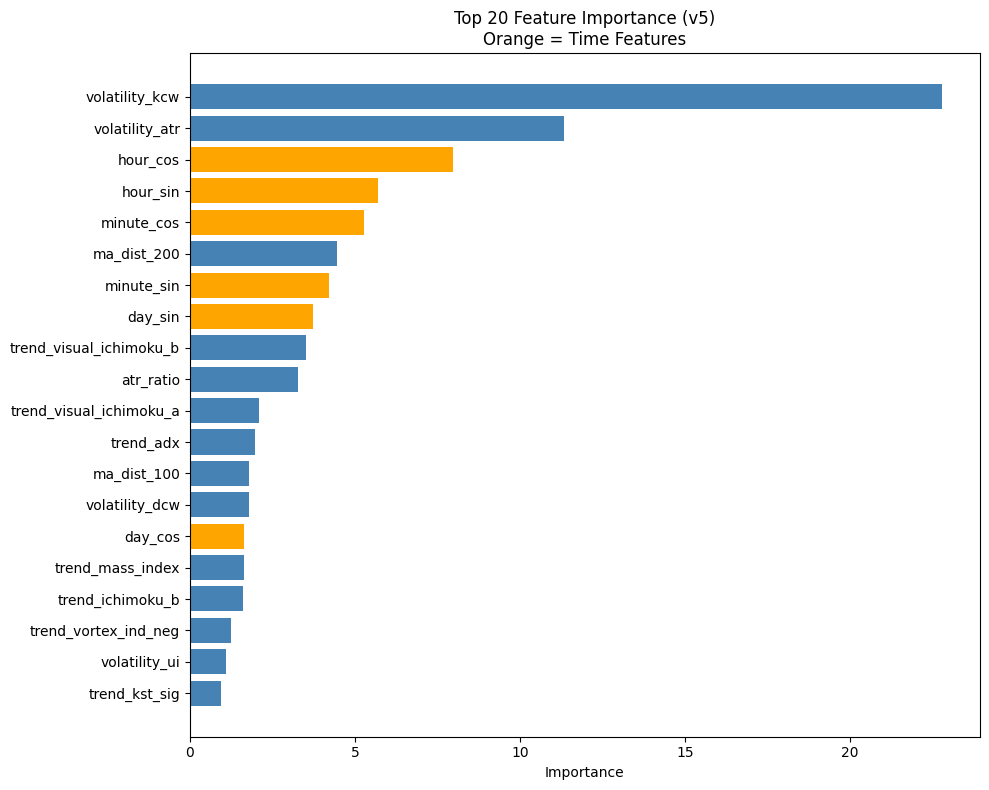

In [16]:
# === Cell 4: Feature Selection with Purged CV (Train Only, v5) ===
print("⏳ Selecting Important Features (v5, Train Only)...")

def purged_time_series_split(n_samples, n_splits, gap):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_idx, val_idx in tscv.split(np.arange(n_samples)):
        if gap > 0:
            train_idx = train_idx[:-gap]
            val_idx = val_idx[gap:]
        if len(train_idx) == 0 or len(val_idx) == 0:
            continue
        yield train_idx, val_idx

importance_scores = []

for fold, (train_idx, val_idx) in enumerate(purged_time_series_split(len(X_train), n_splits=3, gap=CONFIG['CV_GAP'])):
    X_train_fs, X_val_fs = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fs, y_val_fs = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # クラス重み計算
    classes = np.unique(y_train_fs)
    weights = compute_class_weight('balanced', classes=classes, y=y_train_fs)
    class_weights = dict(zip(classes, weights))

    temp_model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.1,
        depth=6,
        loss_function='MultiClass',
        class_weights=class_weights,
        **catboost_device_params(),
        verbose=0,
        random_seed=CONFIG['RANDOM_SEED']
    )

    temp_model.fit(X_train_fs, y_train_fs, eval_set=(X_val_fs, y_val_fs), early_stopping_rounds=30)
    importance_scores.append(temp_model.get_feature_importance())

# 平均重要度で選択
avg_importance = np.mean(importance_scores, axis=0)
df_imp = pd.DataFrame({'feature': X_train.columns, 'importance': avg_importance})
df_imp = df_imp.sort_values('importance', ascending=False)

# 時間特徴量の警告
time_features = ['hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'day_sin', 'day_cos',
                 'is_tokyo_session', 'is_london_session', 'is_ny_session']
top20 = df_imp.head(20)['feature'].tolist()
time_in_top20 = [f for f in top20 if f in time_features]

if len(time_in_top20) >= 5:
    print(f"\n⚠️ 警告: Top 20中に時間特徴量が{len(time_in_top20)}個含まれています！")
    print(f"   該当特徴量: {time_in_top20}")
    print(f"   過学習のリスクがあります。時間帯パターンは市場構造の変化で無効化される可能性があります。")
elif len(time_in_top20) >= 3:
    print(f"\n⚡ 注意: Top 20中に時間特徴量が{len(time_in_top20)}個含まれています。")
    print(f"   該当特徴量: {time_in_top20}")

# 特徴量選択
selected_features = df_imp.head(CONFIG['TOP_N_FEATURES'])['feature'].tolist()

print(f"\n📊 Top 20 Features:")
print(df_imp.head(20).to_string())
print(f"\n✅ Selected Top {CONFIG['TOP_N_FEATURES']} features for training.")

# データセットを更新
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

# 特徴量重要度の可視化
fig, ax = plt.subplots(figsize=(10, 8))
top20_df = df_imp.head(20).iloc[::-1]
colors = ['orange' if f in time_features else 'steelblue' for f in top20_df['feature']]
ax.barh(top20_df['feature'], top20_df['importance'], color=colors)
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importance (v5)\nOrange = Time Features')
plt.tight_layout()
plt.show()


In [17]:
# === Cell 5: Hyperparameter Tuning with Optuna (v5: Trading Objective) ===
print("⏳ Starting Bayesian Optimization (v5, trading objective)...")

def create_target_with_threshold(future_returns_pips, threshold_pips):
    # 指定した閾値（pips）でターゲットを生成
    y = pd.Series(0, index=future_returns_pips.index)
    y[future_returns_pips > threshold_pips] = 1   # Buy
    y[future_returns_pips < -threshold_pips] = 2  # Sell
    return y


def calculate_sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=None):
    if len(returns) == 0:
        return 0
    if periods_per_year is None:
        periods_per_year = 252 * 20 * 60 / CONFIG['PREDICT_HORIZON']
    excess_returns = returns - risk_free_rate
    if excess_returns.std() == 0:
        return 0
    return np.sqrt(periods_per_year) * (excess_returns.mean() / excess_returns.std())


def calc_trade_pnl_pips(preds, future_returns_pips, cost_pips):
    pnl = []
    for pred, fr in zip(preds, future_returns_pips):
        if pred == 1:
            pnl.append(fr - cost_pips)
        elif pred == 2:
            pnl.append(-fr - cost_pips)
    return np.array(pnl)


def predict_with_thresholds(probs, threshold_buy, threshold_sell):
    preds = np.zeros(len(probs), dtype=int)
    for i, (hold_p, buy_p, sell_p) in enumerate(probs):
        if buy_p > threshold_buy and buy_p > sell_p:
            preds[i] = 1
        elif sell_p > threshold_sell and sell_p > buy_p:
            preds[i] = 2
    return preds


def objective_v5(trial):
    threshold_pips = trial.suggest_float('threshold_pips',
                                          CONFIG['THRESHOLD_PIPS_MIN'],
                                          CONFIG['THRESHOLD_PIPS_MAX'])
    prob_threshold = trial.suggest_float('prob_threshold',
                                         CONFIG['PROB_THRESHOLD_MIN'],
                                         CONFIG['PROB_THRESHOLD_MAX'])

    y_opt = create_target_with_threshold(future_returns_pips_train, threshold_pips)

    # クラス重み計算
    classes = np.unique(y_opt)
    if len(classes) < 3:
        return -10  # 全クラスが存在しない場合は強いペナルティ

    weights = compute_class_weight('balanced', classes=classes, y=y_opt)
    class_weights = dict(zip(classes, weights))

    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.12, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.1, 5.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'MultiClassOneVsAll',
        'eval_metric': 'TotalF1',
        'class_weights': class_weights,
        **catboost_device_params(),
        'verbose': 0,
        'early_stopping_rounds': 50,
        'random_seed': CONFIG['RANDOM_SEED']
    }

    cost_pips = CONFIG['SPREAD_PIPS'] + CONFIG['SLIPPAGE_PIPS']
    scores = []

    for train_idx, val_idx in purged_time_series_split(len(X_train), n_splits=CONFIG['CV_SPLITS'], gap=CONFIG['CV_GAP']):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_opt.iloc[train_idx], y_opt.iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=(X_va, y_va))

        probs = model.predict_proba(X_va)
        preds = predict_with_thresholds(probs, prob_threshold, prob_threshold)

        trade_count = int((preds != 0).sum())
        min_trades = max(CONFIG['MIN_TRADES'], int(CONFIG['MIN_TRADE_RATE'] * len(preds)))
        buy_trades = int((preds == 1).sum())
        sell_trades = int((preds == 2).sum())

        if trade_count < min_trades or min(buy_trades, sell_trades) < CONFIG['MIN_SIDE_TRADES']:
            scores.append(-10)
            continue

        pnl_pips = calc_trade_pnl_pips(preds, future_returns_pips_train.iloc[val_idx].values, cost_pips)
        scores.append(calculate_sharpe_ratio(pnl_pips))

    return float(np.mean(scores)) if scores else -10


study = optuna.create_study(direction='maximize')
study.optimize(objective_v5, n_trials=CONFIG['N_TRIALS'], show_progress_bar=True)

# 最適パラメータを保存
BEST_THRESHOLD_PIPS = study.best_params['threshold_pips']
BEST_PROB_THRESHOLD = study.best_params['prob_threshold']
print("\n✅ Best Parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")
print(f"\n📊 Best Trading Sharpe: {study.best_value:.4f}")
print(f"\n🎯 Optimized THRESHOLD_PIPS: {BEST_THRESHOLD_PIPS:.4f}")
print(f"🎯 Optimized PROB_THRESHOLD: {BEST_PROB_THRESHOLD:.4f}")

# 最適閾値でターゲットを再生成（train/val/testに反映）
y_all_opt = create_target_with_threshold(future_returns_pips_valid, BEST_THRESHOLD_PIPS)
y_train = y_all_opt.loc[X_train.index]
y_val = y_all_opt.loc[X_val.index]
y_test = y_all_opt.loc[X_test.index]

# 更新後のクラス分布
print(f"\n📈 Updated Class Distribution (threshold={BEST_THRESHOLD_PIPS:.4f} pips):")
class_counts = y_all_opt.value_counts().sort_index()
for cls, count in class_counts.items():
    print(f"   {class_labels[cls]}: {count:,} ({count/len(y_all_opt)*100:.2f}%)")


⏳ Starting Bayesian Optimization (v5, trading objective)...


Best trial: 0. Best value: -10: 100%|██████████| 1/1 [00:07<00:00,  7.65s/it]


✅ Best Parameters:
   threshold_pips: 3.7242569813711146
   prob_threshold: 0.6881850297601606
   learning_rate: 0.05585534161006123
   depth: 5
   l2_leaf_reg: 0.7301164647541271
   random_strength: 0.21341368577655292
   bagging_temperature: 0.06179546481661724
   border_count: 52

📊 Best Trading Sharpe: -10.0000

🎯 Optimized THRESHOLD_PIPS: 3.7243
🎯 Optimized PROB_THRESHOLD: 0.6882

📈 Updated Class Distribution (threshold=3.7243 pips):
   Hold: 395,375 (47.44%)
   Buy: 223,404 (26.81%)
   Sell: 214,565 (25.75%)


In [18]:
# === Cell 6: Train Final Model & Threshold Optimization (v5) ===
print("⏳ Training Final Model (v5)...")

# クラス重み計算（訓練データのみで）
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_train = dict(zip(classes, weights))
print(f"\n📊 Class Weights (from train only): {class_weights_train}")

# 最終パラメータ（THRESHOLD_PIPSは除外）
final_params = {k: v for k, v in study.best_params.items() if k not in ['threshold_pips', 'prob_threshold']}
final_params.update({
    'iterations': 3000,
    'loss_function': 'MultiClassOneVsAll',
    'eval_metric': 'TotalF1',
    'class_weights': class_weights_train,
    'verbose': 500,
    'early_stopping_rounds': 150,
    'random_seed': CONFIG['RANDOM_SEED']
})
final_params.update(catboost_device_params())

# 訓練（バリデーションデータで早期停止）
model = CatBoostClassifier(**final_params)
model.fit(X_train, y_train, eval_set=(X_val, y_val))


def predict_with_thresholds(probs, threshold_buy, threshold_sell):
    preds = np.zeros(len(probs), dtype=int)
    for i, (hold_p, buy_p, sell_p) in enumerate(probs):
        if buy_p > threshold_buy and buy_p > sell_p:
            preds[i] = 1
        elif sell_p > threshold_sell and sell_p > buy_p:
            preds[i] = 2
    return preds


# === バリデーションデータで閾値最適化（v5: Trading Sharpe）===
print("\n⏳ Optimizing thresholds on VALIDATION data (v5)...")
best_sharpe = -np.inf
best_thresholds = (BEST_PROB_THRESHOLD, BEST_PROB_THRESHOLD)

probs_val = model.predict_proba(X_val)
cost_pips = CONFIG['SPREAD_PIPS'] + CONFIG['SLIPPAGE_PIPS']

for thresh_buy in np.arange(0.20, 0.70, 0.02):
    for thresh_sell in np.arange(0.20, 0.70, 0.02):
        preds = predict_with_thresholds(probs_val, thresh_buy, thresh_sell)
        trade_count = int((preds != 0).sum())
        min_trades = max(CONFIG['MIN_TRADES'], int(CONFIG['MIN_TRADE_RATE'] * len(preds)))
        buy_trades = int((preds == 1).sum())
        sell_trades = int((preds == 2).sum())

        if trade_count < min_trades or min(buy_trades, sell_trades) < CONFIG['MIN_SIDE_TRADES']:
            sharpe = -10
        else:
            pnl_pips = calc_trade_pnl_pips(preds, future_returns_pips_val.values, cost_pips)
            sharpe = calculate_sharpe_ratio(pnl_pips)

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_thresholds = (thresh_buy, thresh_sell)

THRESHOLD_BUY, THRESHOLD_SELL = best_thresholds
print(f"🎯 Optimized Thresholds (from validation): Buy>{THRESHOLD_BUY:.2f}, Sell>{THRESHOLD_SELL:.2f}")
print(f"📊 Best Trading Sharpe on validation: {best_sharpe:.4f}")

# === ATR閾値を学習データから固定 ===
if 'volatility_atr' in df_features.columns:
    atr_series = df_features.loc[X_train.index, 'volatility_atr']
    ATR_THRESHOLD = atr_series.quantile(CONFIG['ATR_PERCENTILE'] / 100)
else:
    ATR_THRESHOLD = 0.0
print(f"\n📈 ATR Threshold (train-based): {ATR_THRESHOLD:.6f}")


⏳ Training Final Model (v5)...

📊 Class Weights (from train only): {0: 0.693218811524277, 1: 1.2561609522876358, 2: 1.3134085667302369}
0:	learn: 0.4294666	test: 0.3984975	best: 0.3984975 (0)	total: 5.08ms	remaining: 15.2s
500:	learn: 0.5151527	test: 0.4132812	best: 0.4142513 (374)	total: 2.51s	remaining: 12.5s
bestTest = 0.4142512573
bestIteration = 374
Shrink model to first 375 iterations.

⏳ Optimizing thresholds on VALIDATION data (v5)...
🎯 Optimized Thresholds (from validation): Buy>0.56, Sell>0.58
📊 Best Trading Sharpe on validation: 20.4128

📈 ATR Threshold (train-based): 0.019412



📊 FINAL MODEL EVALUATION ON TEST DATA (v5)

📈 Overall Metrics (Test Set):
   Accuracy: 0.5217
   Macro F1: 0.2302
   Weighted F1: 0.3586
   Cohen's Kappa: 0.0015

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

        Hold       0.52      1.00      0.69     86877
         Buy       0.58      0.00      0.00     40998
        Sell       0.40      0.00      0.00     38779

    accuracy                           0.52    166654
   macro avg       0.50      0.33      0.23    166654
weighted avg       0.51      0.52      0.36    166654



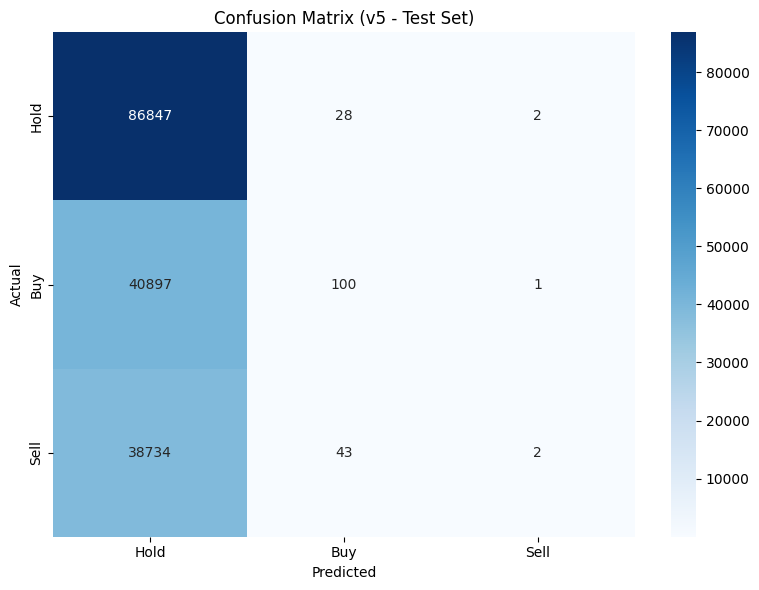


📊 Trading Metrics (Test, no filter):
   Total Trades: 176
   Win Rate: 67.6%
   Total P&L: ¥111,205
   Avg Win: ¥1,582
   Avg Loss: ¥-1,352
   Profit Factor: 2.44
   Sharpe Ratio: 45.64

⏳ Running Advanced Backtest (v5)...

📊 BACKTEST RESULTS (v5)

📈 Performance Summary:
   Total Trades: 101
   Win Rate: 58.4% (59 wins / 42 losses)
   Total P&L: ¥-5,980
   Avg Win: ¥1,072
   Avg Loss: ¥-1,649
   Profit Factor: 0.91
   Max Drawdown: ¥-52,845 (-120.1%)

📊 Risk Metrics:
   Sharpe Ratio: -4.44
   Calmar Ratio: 22.59
   Trading Cost: 0.4500 pips/trade

   BUY: 97 trades, Win Rate: 57.7%, P&L: ¥-7,565

   SELL: 4 trades, Win Rate: 75.0%, P&L: ¥1,585


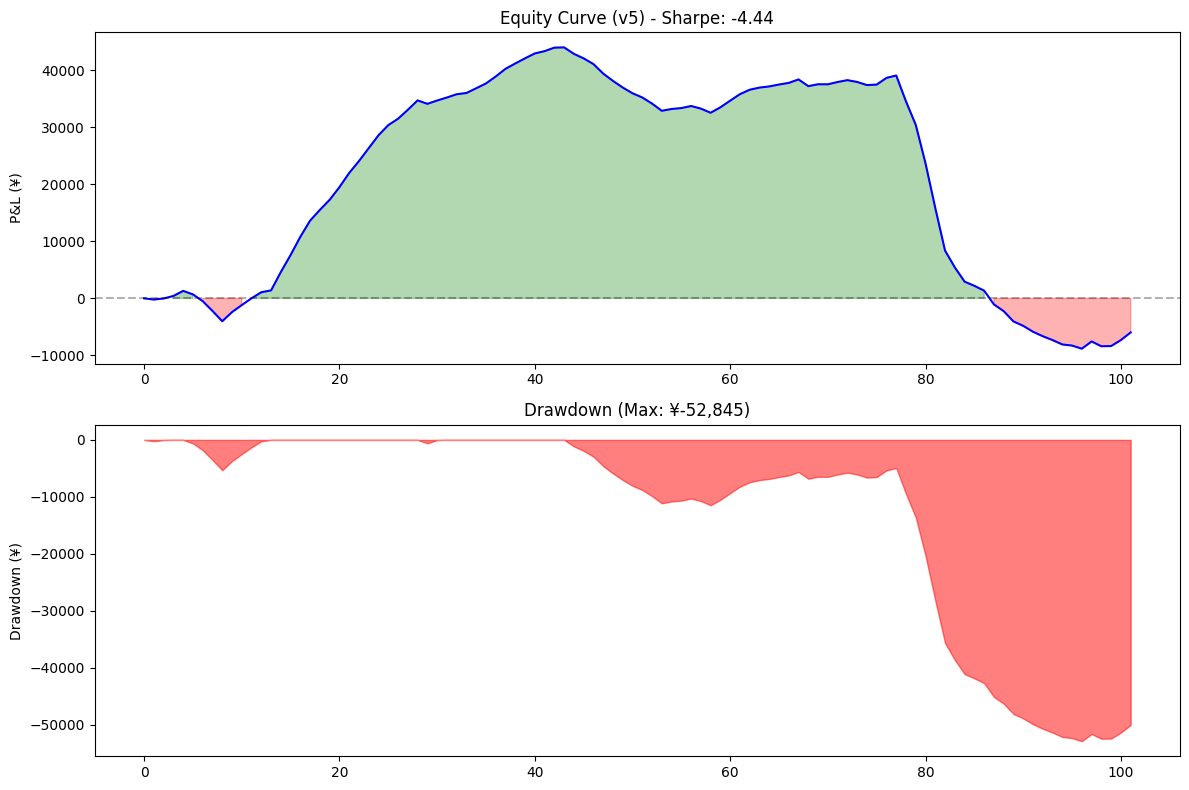

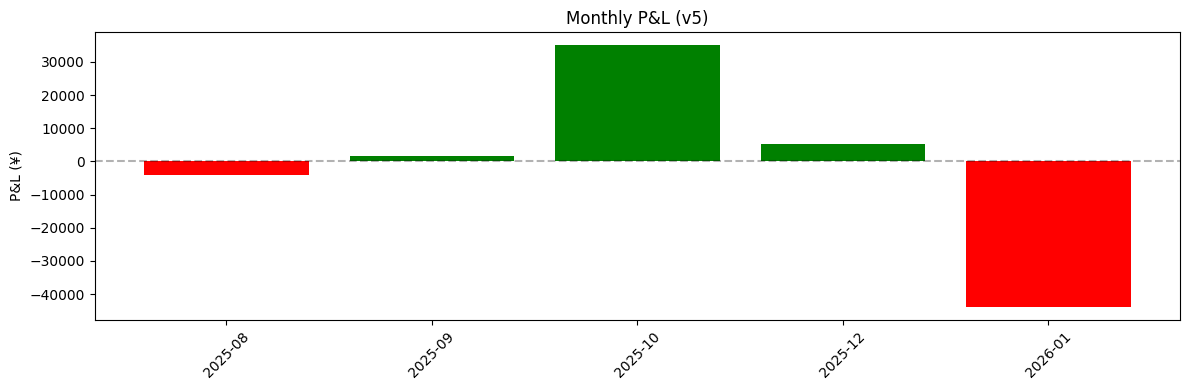

In [19]:
# === Cell 7: Final Evaluation & Advanced Backtest (v5) ===
print("\n" + "="*60)
print("📊 FINAL MODEL EVALUATION ON TEST DATA (v5)")
print("="*60)

# テストデータでの予測（最適化した閾値を使用）
probs_test = model.predict_proba(X_test)
y_pred = predict_with_thresholds(probs_test, THRESHOLD_BUY, THRESHOLD_SELL)

# 基本指標
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

print(f"\n📈 Overall Metrics (Test Set):")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   Macro F1: {macro_f1:.4f}")
print(f"   Weighted F1: {weighted_f1:.4f}")
print(f"   Cohen's Kappa: {kappa:.4f}")

# クラス別レポート
print(f"\n📊 Classification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['Hold', 'Buy', 'Sell']))

# 混同行列
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hold', 'Buy', 'Sell'],
            yticklabels=['Hold', 'Buy', 'Sell'], ax=ax)
ax.set_title('Confusion Matrix (v5 - Test Set)')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.tight_layout()
plt.show()

# === Trading Metrics (Test, no time filter) ===
cost_pips = CONFIG['SPREAD_PIPS'] + CONFIG['SLIPPAGE_PIPS']
pnl_pips = calc_trade_pnl_pips(y_pred, future_returns_pips_test.values, cost_pips)

if len(pnl_pips) > 0:
    total_trades = len(pnl_pips)
    win_rate = (pnl_pips > 0).sum() / total_trades * 100
    total_pnl_yen = pnl_pips.sum() * CONFIG['PIP_SIZE'] * CONFIG['POSITION_SIZE']
    avg_win = pnl_pips[pnl_pips > 0].mean() * CONFIG['PIP_SIZE'] * CONFIG['POSITION_SIZE'] if (pnl_pips > 0).any() else 0
    avg_loss = pnl_pips[pnl_pips < 0].mean() * CONFIG['PIP_SIZE'] * CONFIG['POSITION_SIZE'] if (pnl_pips < 0).any() else 0
    profit_factor = abs(pnl_pips[pnl_pips > 0].sum() / pnl_pips[pnl_pips < 0].sum()) if (pnl_pips < 0).sum() != 0 else float('inf')
    sharpe_test = calculate_sharpe_ratio(pnl_pips)

    print(f"\n📊 Trading Metrics (Test, no filter):")
    print(f"   Total Trades: {total_trades:,}")
    print(f"   Win Rate: {win_rate:.1f}%")
    print(f"   Total P&L: ¥{total_pnl_yen:,.0f}")
    print(f"   Avg Win: ¥{avg_win:,.0f}")
    print(f"   Avg Loss: ¥{avg_loss:,.0f}")
    print(f"   Profit Factor: {profit_factor:.2f}")
    print(f"   Sharpe Ratio: {sharpe_test:.2f}")
else:
    print("\n⚠️ No trades generated in test (no-filter).")


# === Advanced Backtest (v5: Slippage + Sharpe Ratio, unified logic) ===
print("\n⏳ Running Advanced Backtest (v5)...")

def run_backtest_v5(model, X_test, y_test, df_prices, config,
                    threshold_buy=0.4, threshold_sell=0.4):
    probs = model.predict_proba(X_test)
    total_cost = (config['SPREAD_PIPS'] + config['SLIPPAGE_PIPS']) * config['PIP_SIZE']

    results = []
    equity_curve = [0]
    test_indices = X_test.index

    for i, idx in enumerate(test_indices):
        if idx not in df_prices.index:
            continue

        hour = idx.hour

        # 時間帯フィルタ
        if hour in config['BAD_HOURS']:
            continue

        buy_prob = probs[i, 1]
        sell_prob = probs[i, 2]
        actual = y_test.iloc[i]

        entry_price = df_prices.loc[idx, 'close']

        # 決済価格（PREDICT_HORIZON分後）
        exit_idx = idx + pd.Timedelta(minutes=config['PREDICT_HORIZON'])
        if exit_idx in df_prices.index:
            exit_price = df_prices.loc[exit_idx, 'close']
        else:
            continue

        signal = None
        pnl = 0

        if buy_prob > threshold_buy and buy_prob > sell_prob:
            signal = 'BUY'
            pnl = (exit_price - entry_price - total_cost) * config['POSITION_SIZE']
        elif sell_prob > threshold_sell and sell_prob > buy_prob:
            signal = 'SELL'
            pnl = (entry_price - exit_price - total_cost) * config['POSITION_SIZE']

        if signal:
            results.append({
                'timestamp': idx,
                'signal': signal,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'buy_prob': buy_prob,
                'sell_prob': sell_prob,
                'actual': actual,
                'pnl': pnl,
                'win': pnl > 0
            })
            equity_curve.append(equity_curve[-1] + pnl)

    if not results:
        return None, None

    df_results = pd.DataFrame(results)
    return df_results, equity_curve


# バックテスト実行
df_bt, equity = run_backtest_v5(
    model, X_test, y_test, df, CONFIG,
    threshold_buy=THRESHOLD_BUY,
    threshold_sell=THRESHOLD_SELL
)

if df_bt is not None:
    print("\n" + "="*60)
    print("📊 BACKTEST RESULTS (v5)")
    print("="*60)

    total_trades = len(df_bt)
    wins = df_bt['win'].sum()
    losses = total_trades - wins
    win_rate = wins / total_trades * 100

    total_pnl = df_bt['pnl'].sum()
    avg_win = df_bt[df_bt['win']]['pnl'].mean() if wins > 0 else 0
    avg_loss = df_bt[~df_bt['win']]['pnl'].mean() if losses > 0 else 0
    profit_factor = abs(df_bt[df_bt['pnl'] > 0]['pnl'].sum() / df_bt[df_bt['pnl'] < 0]['pnl'].sum()) if df_bt[df_bt['pnl'] < 0]['pnl'].sum() != 0 else float('inf')

    # ドローダウン計算
    equity_series = pd.Series(equity)
    running_max = equity_series.cummax()
    drawdown = equity_series - running_max
    max_drawdown = drawdown.min()
    max_dd_pct = (max_drawdown / running_max.max() * 100) if running_max.max() > 0 else 0

    # Sharpe Ratio
    returns = df_bt['pnl'].values
    sharpe_ratio = calculate_sharpe_ratio(returns)

    # Calmar Ratio（年率リターン / 最大ドローダウン）
    annual_return = total_pnl * (252 * 20 * 60 / CONFIG['PREDICT_HORIZON']) / total_trades if total_trades > 0 else 0
    calmar_ratio = abs(annual_return / max_drawdown) if max_drawdown != 0 else float('inf')

    print(f"\n📈 Performance Summary:")
    print(f"   Total Trades: {total_trades:,}")
    print(f"   Win Rate: {win_rate:.1f}% ({wins} wins / {losses} losses)")
    print(f"   Total P&L: ¥{total_pnl:,.0f}")
    print(f"   Avg Win: ¥{avg_win:,.0f}")
    print(f"   Avg Loss: ¥{avg_loss:,.0f}")
    print(f"   Profit Factor: {profit_factor:.2f}")
    print(f"   Max Drawdown: ¥{max_drawdown:,.0f} ({max_dd_pct:.1f}%)")

    print(f"\n📊 Risk Metrics:")
    print(f"   Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"   Calmar Ratio: {calmar_ratio:.2f}")
    print(f"   Trading Cost: {(CONFIG['SPREAD_PIPS'] + CONFIG['SLIPPAGE_PIPS']):.4f} pips/trade")

    # Buy/Sell別統計
    for signal in ['BUY', 'SELL']:
        df_sig = df_bt[df_bt['signal'] == signal]
        if len(df_sig) > 0:
            sig_wr = df_sig['win'].sum() / len(df_sig) * 100
            sig_pnl = df_sig['pnl'].sum()
            print(f"\n   {signal}: {len(df_sig)} trades, Win Rate: {sig_wr:.1f}%, P&L: ¥{sig_pnl:,.0f}")

    # エクイティカーブ
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    axes[0].plot(equity, color='blue')
    axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[0].fill_between(range(len(equity)), equity, 0,
                         where=[e >= 0 for e in equity], alpha=0.3, color='green')
    axes[0].fill_between(range(len(equity)), equity, 0,
                         where=[e < 0 for e in equity], alpha=0.3, color='red')
    axes[0].set_title(f'Equity Curve (v5) - Sharpe: {sharpe_ratio:.2f}')
    axes[0].set_ylabel('P&L (¥)')

    axes[1].fill_between(range(len(drawdown)), drawdown, 0, alpha=0.5, color='red')
    axes[1].set_title(f'Drawdown (Max: ¥{max_drawdown:,.0f})')
    axes[1].set_ylabel('Drawdown (¥)')

    plt.tight_layout()
    plt.show()

    # 月次パフォーマンス
    df_bt['month'] = df_bt['timestamp'].dt.to_period('M')
    monthly_pnl = df_bt.groupby('month')['pnl'].sum()

    fig, ax = plt.subplots(figsize=(12, 4))
    colors = ['green' if p > 0 else 'red' for p in monthly_pnl.values]
    ax.bar(range(len(monthly_pnl)), monthly_pnl.values, color=colors)
    ax.set_xticks(range(len(monthly_pnl)))
    ax.set_xticklabels([str(m) for m in monthly_pnl.index], rotation=45)
    ax.set_title('Monthly P&L (v5)')
    ax.set_ylabel('P&L (¥)')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No trades generated. Adjust thresholds or check data.")


In [20]:
# === Cell 8: Save Artifacts (v5) ===
print("⏳ Saving artifacts (v5)...")

model_path = ARTIFACT_DIR / "catboost_usdjpy_v5.cbm"
model.save_model(model_path)

features_path = ARTIFACT_DIR / "selected_features_v5.pkl"
with open(features_path, 'wb') as f:
    pickle.dump(selected_features, f)

# v5: 最適化された閾値とATR閾値を保存
config_v5 = CONFIG.copy()
config_v5['THRESHOLD_PIPS'] = BEST_THRESHOLD_PIPS
config_v5['THRESHOLD_BUY'] = THRESHOLD_BUY
config_v5['THRESHOLD_SELL'] = THRESHOLD_SELL
config_v5['ATR_THRESHOLD'] = ATR_THRESHOLD

config_path = ARTIFACT_DIR / "config_v5.pkl"
with open(config_path, 'wb') as f:
    pickle.dump(config_v5, f)

print(f"\n✅ Model saved as '{model_path}'")
print(f"✅ Features list saved as '{features_path}'")
print(f"✅ Config saved as '{config_path}'")

for p in [model_path, features_path, config_path]:
    if p.exists():
        maybe_download(p)

⏳ Saving artifacts (v5)...

✅ Model saved as 'artifacts\catboost_usdjpy_v5.cbm'
✅ Features list saved as 'artifacts\selected_features_v5.pkl'
✅ Config saved as 'artifacts\config_v5.pkl'
📁 Saved locally: artifacts\catboost_usdjpy_v5.cbm
📁 Saved locally: artifacts\selected_features_v5.pkl
📁 Saved locally: artifacts\config_v5.pkl


In [21]:
# === Cell 9: Load Model & Verify (v5) ===
import pickle
from catboost import CatBoostClassifier

print("⏳ Loading Model & Verifying (v5)...")

model_path = ARTIFACT_DIR / "catboost_usdjpy_v5.cbm"
features_path = ARTIFACT_DIR / "selected_features_v5.pkl"
config_path = ARTIFACT_DIR / "config_v5.pkl"

if not all(p.exists() for p in [model_path, features_path, config_path]):
    raise FileNotFoundError("🚨 Model or config files not found. Please run Cell 8 first.")

# モデルロード
loaded_model = CatBoostClassifier()
loaded_model.load_model(str(model_path))
print(f"✅ Model loaded from '{model_path}'")

# 特徴量ロード
with open(features_path, 'rb') as f:
    loaded_features = pickle.load(f)
print(f"✅ Features list loaded ({len(loaded_features)} features)")

# 設定ロード
with open(config_path, 'rb') as f:
    loaded_config = pickle.load(f)
print(f"✅ Config loaded")

# 閾値を変数に保存（推論で使用）
THRESHOLD_BUY_FINAL = loaded_config['THRESHOLD_BUY']
THRESHOLD_SELL_FINAL = loaded_config['THRESHOLD_SELL']

print(f"\n📊 Ready for Inference (v5):")
print(f"   THRESHOLD_PIPS: {loaded_config['THRESHOLD_PIPS']:.4f}")
print(f"   Buy Threshold: {THRESHOLD_BUY_FINAL:.4f}")
print(f"   Sell Threshold: {THRESHOLD_SELL_FINAL:.4f}")
print(f"   Slippage: {loaded_config['SLIPPAGE_PIPS']:.4f} pips")
print(f"   Timezone: {loaded_config.get('TIMEZONE', 'UTC')}")

⏳ Loading Model & Verifying (v5)...
✅ Model loaded from 'artifacts\catboost_usdjpy_v5.cbm'
✅ Features list loaded (40 features)
✅ Config loaded

📊 Ready for Inference (v5):
   THRESHOLD_PIPS: 3.7243
   Buy Threshold: 0.5600
   Sell Threshold: 0.5800
   Slippage: 0.0500 pips
   Timezone: UTC


In [22]:
# === Cell 10: Realtime Inference (v5 with GMO Coin FX API) ===
import requests
import json
import pandas as pd
from datetime import datetime, timedelta, timezone
import numpy as np
import ta

def fetch_gmo_data_v5(symbol='USD_JPY', interval='1min', days=5):
    # GMOコインの外国為替FX Public APIから直近データを取得
    base_url = "https://forex-api.coin.z.com/public/v1/klines"
    jst_now = datetime.now(timezone.utc) + timedelta(hours=9)

    dates_to_fetch = [(jst_now - timedelta(days=i)).strftime('%Y%m%d') for i in range(days)]
    dates_to_fetch.reverse()

    all_data = []
    for date_str in dates_to_fetch:
        try:
            params = {
                'symbol': symbol,
                'interval': interval,
                'date': date_str,
                'priceType': 'ASK'
            }
            response = requests.get(base_url, params=params, timeout=10)
            data = response.json()

            if data['status'] == 0 and data['data']:
                all_data.extend(data['data'])
        except Exception as e:
            print(f"⚠️ API Fetch Error for {date_str}: {e}")
            continue

    if not all_data:
        raise ValueError("❌ Failed to fetch data. Check API status or symbol.")

    df = pd.DataFrame(all_data)

    if 'openTime' not in df.columns:
        raise ValueError('Missing openTime in API response')

    open_raw = pd.to_numeric(df['openTime'], errors='coerce')
    if open_raw.isna().all():
        # Fallback: parse as datetime strings
        unit = None
        ts = pd.to_datetime(df['openTime'], utc=True, errors='coerce')
    else:
        max_abs = open_raw.dropna().abs().max()
        if max_abs < 1e11:
            unit = 's'
        elif max_abs < 1e14:
            unit = 'ms'
        elif max_abs < 1e17:
            unit = 'us'
        else:
            unit = 'ns'
        ts = pd.to_datetime(open_raw, unit=unit, utc=True, errors='coerce')

    if ts.isna().any():
        bad = int(ts.isna().sum())
        print(f"WARN: dropped {bad} rows with invalid openTime (unit={unit})")

    df['openTime'] = ts
    df = df.dropna(subset=['openTime'])
    df = df.set_index('openTime').sort_index()
    df = df[~df.index.duplicated(keep='last')]

    for c in ['open', 'high', 'low', 'close']:
        df[c] = df[c].astype(float)

    df.rename(columns={
        'open': 'ask_open',
        'high': 'ask_high',
        'low': 'ask_low',
    }, inplace=True)

    if 'volume' not in df.columns:
        df['volume'] = 1.0

    return df


def generate_features_v5(df):
    # v5用特徴量生成
    calc_df = df.copy()

    # TA特徴量
    calc_df = ta.add_all_ta_features(
        calc_df, open="ask_open", high="ask_high", low="ask_low",
        close="close", volume="volume", fillna=True
    )

    # taの大量追加で断片化しやすいので一度デフラグ
    calc_df = calc_df.copy()

    new_cols = {}

    # 移動平均乖離率
    for window in [20, 50, 100, 200]:
        sma = calc_df['close'].rolling(window).mean()
        new_cols[f'ma_dist_{window}'] = (calc_df['close'] - sma) / sma

    # EMA乖離率
    for window in [12, 26]:
        ema = calc_df['close'].ewm(span=window).mean()
        new_cols[f'ema_dist_{window}'] = (calc_df['close'] - ema) / ema

    # ボラティリティ関連
    if 'volatility_atr' in calc_df.columns:
        new_cols['atr_ratio'] = calc_df['volatility_atr'] / calc_df['volatility_atr'].rolling(30).mean()
    else:
        new_cols['atr_ratio'] = 1.0

    if 'volatility_bbh' in calc_df.columns and 'volatility_bbl' in calc_df.columns:
        new_cols['bb_width'] = (calc_df['volatility_bbh'] - calc_df['volatility_bbl']) / calc_df['close']

    # リターン系特徴量
    for lag in [1, 5, 15, 60]:
        new_cols[f'return_{lag}'] = calc_df['close'].pct_change(lag)

    # 時間特徴量
    idx = calc_df.index
    new_cols['hour_sin'] = np.sin(2 * np.pi * idx.hour / 24)
    new_cols['hour_cos'] = np.cos(2 * np.pi * idx.hour / 24)
    new_cols['minute_sin'] = np.sin(2 * np.pi * idx.minute / 60)
    new_cols['minute_cos'] = np.cos(2 * np.pi * idx.minute / 60)
    new_cols['day_sin'] = np.sin(2 * np.pi * idx.dayofweek / 7)
    new_cols['day_cos'] = np.cos(2 * np.pi * idx.dayofweek / 7)

    # セッション特徴量
    new_cols['is_tokyo_session'] = ((idx.hour >= 0) & (idx.hour < 9)).astype(int)
    new_cols['is_london_session'] = ((idx.hour >= 8) & (idx.hour < 17)).astype(int)
    new_cols['is_ny_session'] = ((idx.hour >= 13) & (idx.hour < 22)).astype(int)

    new_cols_df = pd.DataFrame(new_cols, index=calc_df.index)
    calc_df = pd.concat([calc_df, new_cols_df], axis=1)

    return calc_df


def predict_signal_v5(model, features, config, threshold_buy, threshold_sell):
    # v5推論関数
    print("⏳ Fetching Realtime Data from GMO Coin FX API...")

    try:
        base_df = fetch_gmo_data_v5(symbol='USD_JPY', days=5)
    except Exception as e:
        return f"🚨 DATA ERROR: {e}"

    if len(base_df) < 500:
        return f"⚠️ NOT ENOUGH DATA: {len(base_df)} rows (Need > 500)"

    # 特徴量生成
    calc_df = generate_features_v5(base_df)

    # 最新行を取得
    latest_row = calc_df.tail(1)
    latest_time = latest_row.index[0]

    # 欠損特徴量のチェック
    missing_features = [f for f in features if f not in calc_df.columns]
    if missing_features:
        print(f"⚠️ Missing features: {missing_features}")
        for f in missing_features:
            calc_df[f] = 0

    X_latest = latest_row[features].fillna(0)

    # フィルタリング
    curr_hour = latest_time.hour
    curr_atr = calc_df['volatility_atr'].iloc[-1] if 'volatility_atr' in calc_df.columns else 0.0
    atr_threshold = config.get('ATR_THRESHOLD', 0.0)
    curr_close = calc_df['close'].iloc[-1]

    res_prefix = f"[{latest_time.strftime('%Y-%m-%d %H:%M')} {config.get('TIMEZONE','UTC')}] {curr_close:.3f} | "

    if curr_hour in config['BAD_HOURS']:
        return res_prefix + f"🛑 SKIP (Low Liquidity Hour: {curr_hour}h {config.get('TIMEZONE','UTC')})"

    if atr_threshold > 0 and curr_atr < atr_threshold:
        return res_prefix + f"💤 SKIP (Low Vol: ATR {curr_atr:.4f} < {atr_threshold:.4f})"

    # 予測
    probs = model.predict_proba(X_latest)[0]
    hold_p, buy_p, sell_p = probs[0], probs[1], probs[2]

    if buy_p > threshold_buy and buy_p > sell_p:
        return res_prefix + f"🚀 BUY SIGNAL (Prob: {buy_p:.1%}, Confidence: {buy_p-sell_p:.1%})"
    elif sell_p > threshold_sell and sell_p > buy_p:
        return res_prefix + f"↘️ SELL SIGNAL (Prob: {sell_p:.1%}, Confidence: {sell_p-buy_p:.1%})"
    else:
        return res_prefix + f"👀 WAIT (Hold:{hold_p:.1%} Buy:{buy_p:.1%} Sell:{sell_p:.1%})"


# === 実行 ===
print(f"📊 Config (v5):")
print(f"   THRESHOLD_PIPS: {loaded_config['THRESHOLD_PIPS']:.4f}")
print(f"   Buy Threshold: {THRESHOLD_BUY_FINAL:.4f}")
print(f"   Sell Threshold: {THRESHOLD_SELL_FINAL:.4f}")
print(f"   Bad Hours (UTC): {loaded_config['BAD_HOURS']}")


decision = predict_signal_v5(
    loaded_model,
    loaded_features,
    loaded_config,
    THRESHOLD_BUY_FINAL,
    THRESHOLD_SELL_FINAL
)
print(f"\n🎯 Result: {decision}")


📊 Config (v5):
   THRESHOLD_PIPS: 3.7243
   Buy Threshold: 0.5600
   Sell Threshold: 0.5800
   Bad Hours (UTC): [20, 21, 22, 23]
⏳ Fetching Realtime Data from GMO Coin FX API...
0    1769720400000
1    1769720460000
2    1769720520000
3    1769720580000
4    1769720640000
Name: openTime, dtype: object

🎯 Result: [2026-02-03 14:26 UTC] 156.018 | 👀 WAIT (Hold:22.5% Buy:37.0% Sell:40.3%)


⏳ Analyzing Feature Importance with SHAP (v5)...


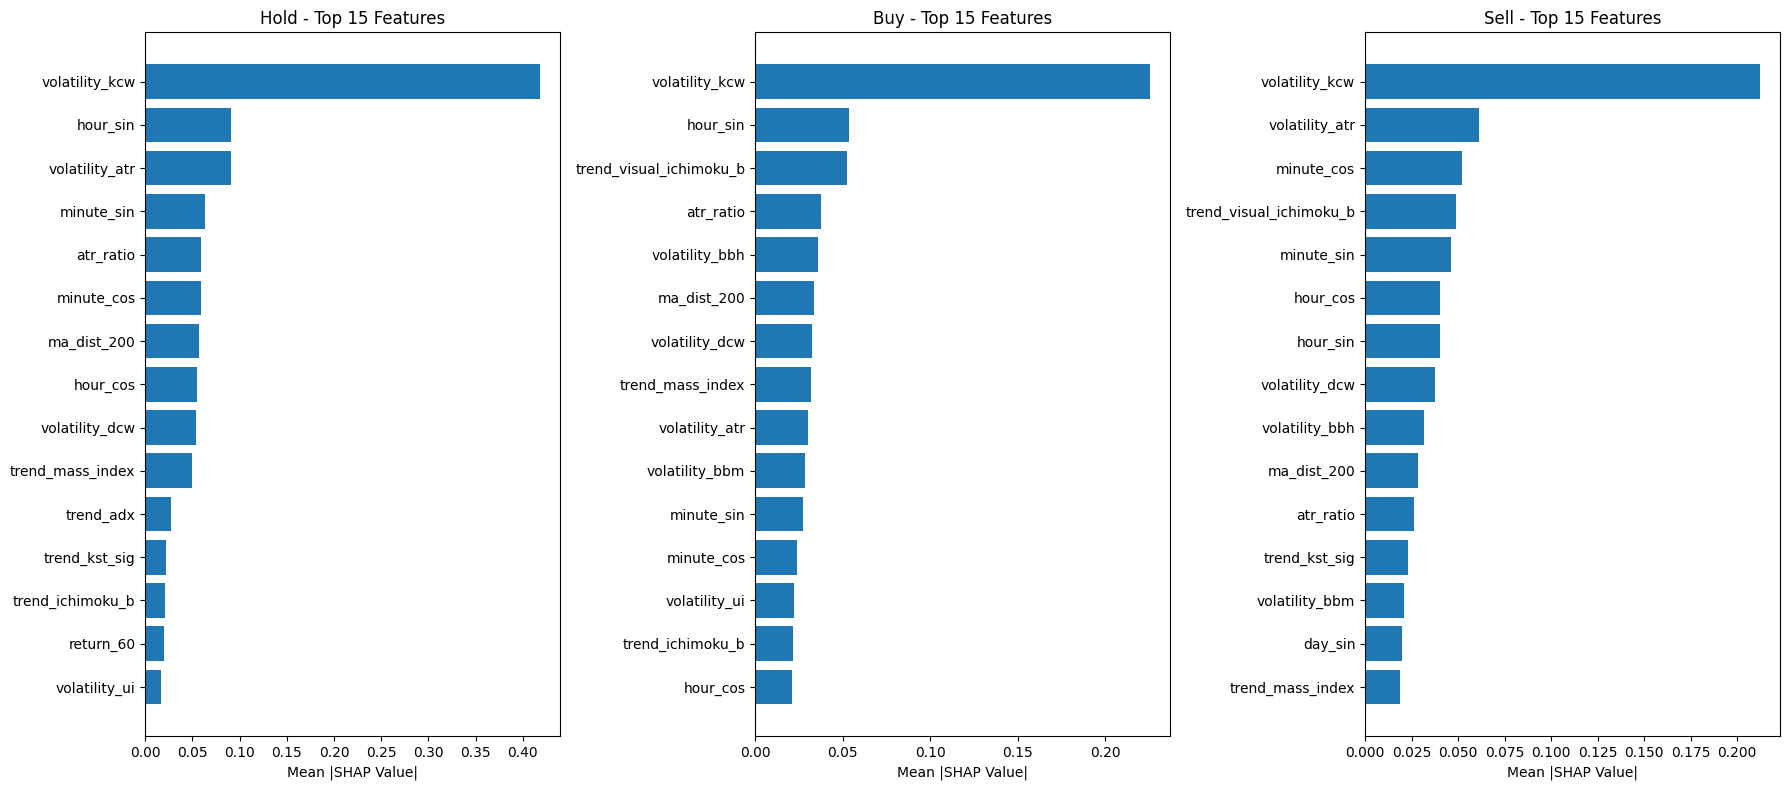

✅ SHAP analysis completed and saved as 'shap_analysis_v5.png'


In [23]:
# === Cell 11: SHAP Feature Importance Analysis (v5) ===
print("⏳ Analyzing Feature Importance with SHAP (v5)...")

# サンプルデータ（計算時間短縮のため）
sample_size = min(5000, len(X_test))
X_sample = X_test.sample(n=sample_size, random_state=CONFIG['RANDOM_SEED'])

# SHAP計算
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# クラス別SHAP importance
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
class_names = ['Hold', 'Buy', 'Sell']

for i, (ax, name) in enumerate(zip(axes, class_names)):
    if isinstance(shap_values, list):
        sv = shap_values[i]
    else:
        sv = shap_values[:, :, i]

    importance = np.abs(sv).mean(axis=0)
    sorted_idx = np.argsort(importance)[-15:]

    ax.barh(range(len(sorted_idx)), importance[sorted_idx])
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels([selected_features[i] for i in sorted_idx])
    ax.set_title(f'{name} - Top 15 Features')
    ax.set_xlabel('Mean |SHAP Value|')

plt.tight_layout()
plt.show()
